In [1]:
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import string
import numpy as np

In [2]:
CLONE_CLASSES = ['__background__', 'holoclone', 'meroclone', 'paraclone']

In [3]:
df_dt = pd.read_csv('./test_res.csv')
df_dt['bbox_idx_dt'] = df_dt.index
df_dt['label_dt'] = df_dt['label_dt'].map(lambda x: CLONE_CLASSES[x])

In [4]:
df_dt = df_dt[df_dt['scores']>0.5]

In [5]:
df_gt = pd.read_csv('../data/test_day6.csv')
df_gt['x1_gt'] = df_gt['x1']
df_gt['y1_gt'] = df_gt['y1']
df_gt['x2_gt'] = df_gt['x2']
df_gt['y2_gt'] = df_gt['y2']
df_gt['label_gt'] = df_gt['label'].map(lambda x: x.strip(string.digits))
df_gt['bbox_idx_gt'] = df_gt.index
# size = df_gt['size'].tolist()[0]

In [6]:
# df_dt['x1_dt'] = (df_dt['x1_dt'] * (size / df_dt['resize']))
# df_dt['y1_dt'] = (df_dt['y1_dt'] * (size / df_dt['resize']))
# df_dt['x2_dt'] = (df_dt['x2_dt'] * (size / df_dt['resize']))
# df_dt['y2_dt'] = (df_dt['y2_dt'] * (size / df_dt['resize']))

In [7]:
from data.utils import calc_mAP, get_df_iou
# calc_mAP(df_dt, df_gt)

In [8]:
# df_dt

In [9]:
# df_gt

In [10]:
image_id = df_gt.sample(1)['image_id'].tolist()[0]
df_gt_sample = df_gt[df_gt['image_id']==image_id]
df_gt_sample

day      label  size  width  height               filename  \
539    6  paraclone   896     77      93  1638710734_711749.png   
540    6  paraclone   896     55      45  1638710734_711749.png   

                  filename_gfp               filename_ph   x1   y1  ...  \
539  1638710734_711749_gfp.png  1638710734_711749_ph.png  218   18  ...   
540  1638710734_711749_gfp.png  1638710734_711749_ph.png  422  249  ...   

     batch  bbox_idx  image_id  is_unknown  x1_gt  y1_gt  x2_gt  y2_gt  \
539      2     16047      8749           0    218     18    295    111   
540      2     16048      8749           0    422    249    477    294   

      label_gt  bbox_idx_gt  
539  paraclone          539  
540  paraclone          540  

[2 rows x 30 columns]

In [11]:
df_dt_sample = df_dt[df_dt['image_id']==image_id]
df_dt_sample

x1_dt       y1_dt      x2_dt      y2_dt   label_dt  image_id  \
999   223.78511   19.370594  296.83557  107.44470  paraclone      8749   
1000  420.72275  251.434590  478.86734  295.64673  paraclone      8749   

      resize    scores  bbox_idx_dt  
999      896  0.999755          999  
1000     896  0.999398         1000

In [12]:
img = cv2.imread('../data/img_clip_all/' + df_gt_sample['filename_gfp'].tolist()[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [13]:
for i in range(len(df_gt_sample)):
    img = cv2.rectangle(img,
                        (int(df_gt_sample.iloc[i]['x1_gt']), int(df_gt_sample.iloc[i]['y1_gt'])),
                        (int(df_gt_sample.iloc[i]['x2_gt']), int(df_gt_sample.iloc[i]['y2_gt'])),
                        (255,0,0),
                        2)

In [14]:
for i in range(len(df_dt_sample)):
    img = cv2.rectangle(img,
                        (int(df_dt_sample.iloc[i]['x1_dt']), int(df_dt_sample.iloc[i]['y1_dt'])),
                        (int(df_dt_sample.iloc[i]['x2_dt']), int(df_dt_sample.iloc[i]['y2_dt'])),
                        (0,255,255),
                        2)

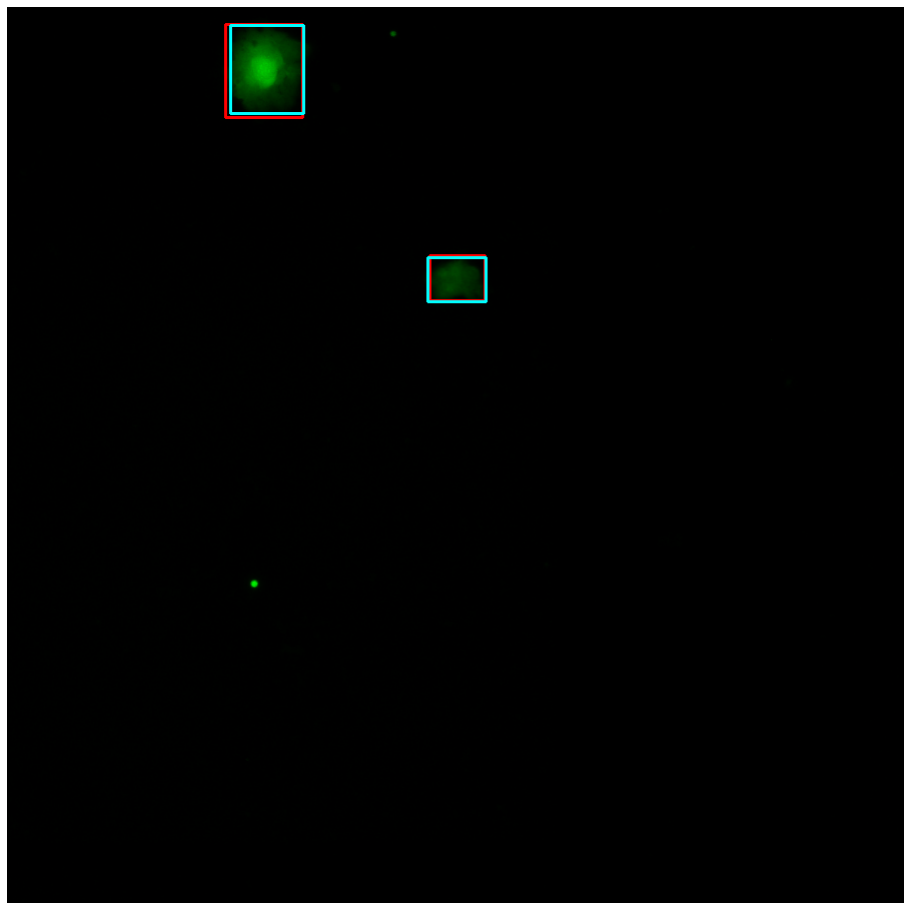

In [15]:
width, height = img.shape[1], img.shape[0]
img = np.ascontiguousarray(img)
fig = plt.figure(frameon=False)
canvas = fig.canvas
dpi = fig.get_dpi()
fig.set_size_inches((width + 1e-8) / dpi, (height + 1e-8) / dpi)
plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
ax = plt.gca()
ax.axis('off')
plt.imshow(img)

In [16]:
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM
from pytorch_grad_cam import GuidedBackpropReLUModel
from pytorch_grad_cam.utils.image import show_cam_on_image, deprocess_image
from models.detection import fasterrcnn_resnet_fpn
from data.datasets import CLONE_CLASSES, get_transforms
from CFG import CFG
import torch
import pandas as pd
import cv2 
import os
import string
from matplotlib import pyplot as plt
import numpy as np
from torchvision.transforms import functional as F
import copy

In [17]:
class GradCAM_DET(GradCAM):
    def __init__(self, model, target_layers, use_cuda=False,
                 reshape_transform=None):
        super(
            GradCAM_DET,
            self).__init__(
            model,
            target_layers,
            use_cuda,
            reshape_transform)
    def get_loss(self, output, target_category):
        loss = 0
        for i in range(len(target_category)):
            scores = output[0]['boxes']
            labels = output[0]['labels']
            loss = loss + scores[labels==target_category[i]].sum()
        return loss

In [18]:
model = fasterrcnn_resnet_fpn(num_classes=len(CLONE_CLASSES), pretrained_backbone=True, trainable_backbone_layers=5, backbone_name='resnet18')
checkpoint_dict = torch.load('./20211220_0226_23/model_best_mFS50_50.pth', map_location='cpu')
if "state_dict" in checkpoint_dict:
    checkpoint_dict = checkpoint_dict["state_dict"]
model_dict = model.state_dict()
if "module" in list(checkpoint_dict.keys())[0] and "module" not in list(model_dict.keys())[0]:
    checkpoint_dict = {k.partition('module.')[2]: v for k, v in checkpoint_dict.items()}
if "model" in list(checkpoint_dict.keys())[0] and "model" not in list(model_dict.keys())[0]:
    checkpoint_dict = {k.partition('model.')[2]: v for k, v in checkpoint_dict.items()}
    checkpoint_dict = {k: v for k, v in checkpoint_dict.items() if (k in model_dict)}
model_dict.update(checkpoint_dict)
model.load_state_dict(model_dict)
device = CFG.DEVICE
model = model.to(device)
model.eval()
device

device(type='cuda')

In [19]:
img = cv2.imread('../data/img_clip_all/' + df_gt_sample['filename_gfp'].tolist()[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
images = F.to_tensor(img).unsqueeze(0).to(device)

# with torch.no_grad():
#     outputs = model(images)[0]
    
# boxes = outputs['boxes'].to('cpu')
# scores = outputs['scores'].to('cpu')
# labels = outputs['labels'].to('cpu')

# df_dt_sample = pd.DataFrame(data=[[float(item) for item in list(box)] + [float(score)] + [float(label)] for box, score, label in zip(boxes, scores, labels)], 
#                      columns=['x1_dt', 'y1_dt', 'x2_dt', 'y2_dt', 'score', 'label_dt'])
# df_dt_sample['label_dt'] = df_dt_sample['label_dt'].astype('int')

# df_dt_sample = df_dt_sample[df_dt_sample['score']>0.50]

In [20]:
CLONE_CLASSES

['__background__', 'holoclone', 'meroclone', 'paraclone']

In [22]:
df_gt_sample

day      label  size  width  height               filename  \
539    6  paraclone   896     77      93  1638710734_711749.png   
540    6  paraclone   896     55      45  1638710734_711749.png   

                  filename_gfp               filename_ph   x1   y1  ...  \
539  1638710734_711749_gfp.png  1638710734_711749_ph.png  218   18  ...   
540  1638710734_711749_gfp.png  1638710734_711749_ph.png  422  249  ...   

     batch  bbox_idx  image_id  is_unknown  x1_gt  y1_gt  x2_gt  y2_gt  \
539      2     16047      8749           0    218     18    295    111   
540      2     16048      8749           0    422    249    477    294   

      label_gt  bbox_idx_gt  
539  paraclone          539  
540  paraclone          540  

[2 rows x 30 columns]

In [21]:
df_dt_sample

x1_dt       y1_dt      x2_dt      y2_dt   label_dt  image_id  \
999   223.78511   19.370594  296.83557  107.44470  paraclone      8749   
1000  420.72275  251.434590  478.86734  295.64673  paraclone      8749   

      resize    scores  bbox_idx_dt  
999      896  0.999755          999  
1000     896  0.999398         1000

In [23]:
target_category = 3

In [34]:
cur_model = copy.deepcopy(model)
cam = GradCAM_DET(model=cur_model, target_layers=[cur_model.backbone.body.layer3[-1]], use_cuda=device)
grayscale_cam = cam(input_tensor=images, target_category=target_category)
grayscale_cam = grayscale_cam[0, :]
grayscale_cam = cv2.resize(
    grayscale_cam,
    (img.shape[1], img.shape[0]), # (w, h)
    interpolation=cv2.INTER_LINEAR,
)
visualization = show_cam_on_image((img/255.).astype(float), grayscale_cam, use_rgb=True)

In [35]:
font = cv2.FONT_HERSHEY_SIMPLEX

In [36]:
img_gt = img.copy()
for i in range(len(df_gt_sample)):
    img_gt = cv2.rectangle(img_gt,
                        (int(df_gt_sample.iloc[i]['x1_gt']), int(df_gt_sample.iloc[i]['y1_gt'])),
                        (int(df_gt_sample.iloc[i]['x2_gt']), int(df_gt_sample.iloc[i]['y2_gt'])),
                        (255, 0, 0),
                        1)
    label = df_gt_sample.iloc[i]['label_gt']
    img_gt = cv2.putText(img_gt, label, 
                      (int(df_gt_sample.iloc[i]['x1_gt']), int(df_gt_sample.iloc[i]['y1_gt'])-1),
                      font, 0.5, (255, 0, 0), 1)

In [37]:
img_dt = img.copy()
for i in range(len(df_dt_sample)):
    img_dt = cv2.rectangle(img_dt,
                        (int(df_dt_sample.iloc[i]['x1_dt']), int(df_dt_sample.iloc[i]['y1_dt'])),
                        (int(df_dt_sample.iloc[i]['x2_dt']), int(df_dt_sample.iloc[i]['y2_dt'])),
                        (0, 255, 0),
                        1)
    label = df_dt_sample.iloc[i]['label_dt']
    img_dt = cv2.putText(img_dt, label, 
                      (int(df_dt_sample.iloc[i]['x1_dt']), int(df_dt_sample.iloc[i]['y1_dt'])-1),
                      font, 0.5, (0, 255, 0), 1)

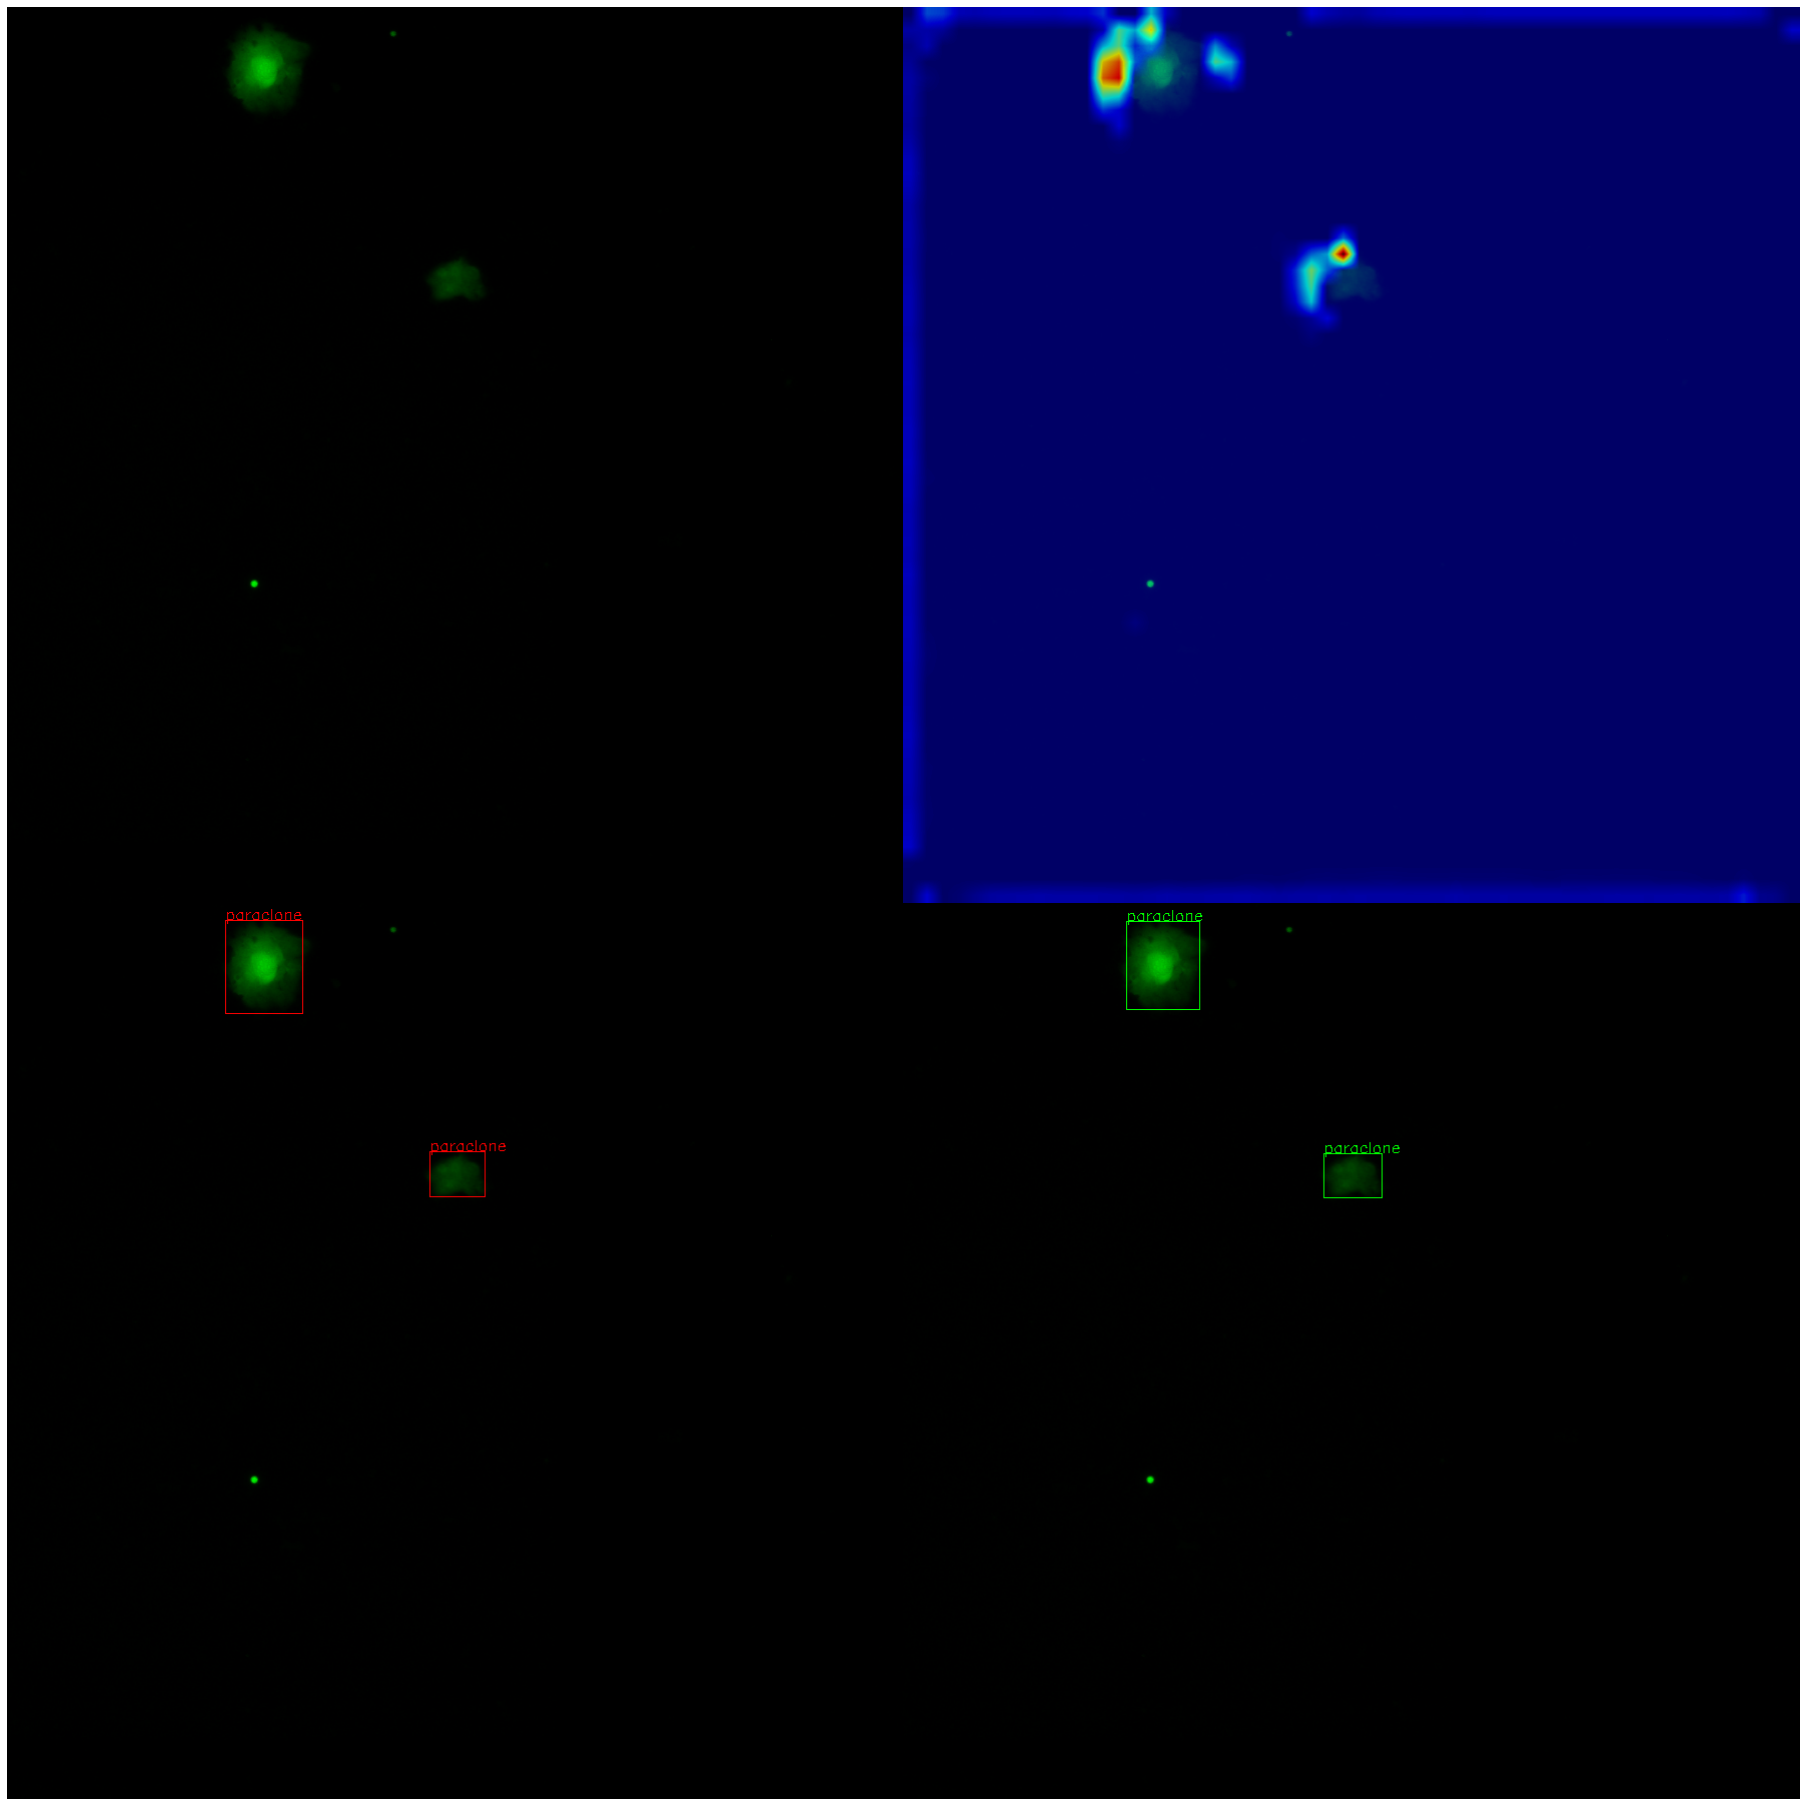

In [38]:
width, height = img.shape[1], img.shape[0]
img = np.ascontiguousarray(img)
visualization = np.ascontiguousarray(visualization)
fig = plt.figure(frameon=False)
dpi = fig.get_dpi()
fig.set_size_inches((width + 1e-8) / dpi*2, (height + 1e-8) / dpi * 2)
fig.tight_layout() # 调整整体空白 
plt.subplots_adjust(left=0, right=1, bottom=0, top=1, wspace=0, hspace=0)
ax1 = plt.subplot(221)
ax1.axis('off')
ax2 = plt.subplot(222)
ax2.axis('off')
ax3 = plt.subplot(223)
ax3.axis('off')
ax4 = plt.subplot(224)
ax4.axis('off')
ax1.imshow(img)
ax2.imshow(visualization)
ax3.imshow(img_gt)
ax4.imshow(img_dt)
plt.show()